## GLMAT: 2D kernel, song stimuli, ML+MC estimation

This notebook demonstrates the full assimilation technique using song stimuli. The song waveform is processed to a 2D spectrogram, then convolved with a 2D STRF to produce the "voltage" of the GLMAT model. The adaptation "current" is calculated by convolving the spike trains with two exponential kernels. The goal of the assimilation is to estimate the parameters of the RF and the adaptation kernels. The parameter count of the RF is minimized by using a low-rank approximation (i.e., an outer product of two vectors) and by projecting time into a basis set of raised cosine filters that are spaced exponentially.

The approach is to use elastic-net penalized maximum-likelihood estimation to get a first guess at the parameters. The regularization parameters and rank are selected using cross-validation. Then MCMC is used to sample the posterior distribution of the parameters.

In [2]:
from __future__ import print_function, division
import os
import sys
import imp
import numpy as np
from scipy import signal as ss

import yaml
import pickle

import mat_neuron._model as mat
from dstrf import strf, mle, io, performance, spikes
import progressbar

# plotting packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'


tag = "test"
saveplace = ""


In [3]:
with open("../../scripts/rothman.yml","r") as yf:
    config = yaml.load(yf)
    
# set variables based on `config`
ntaus = len(config["mat"]["taus"])
mat_fixed = np.asanyarray(config["mat"]["taus"] + [config["mat"]["refract"]],dtype='d')
upsample = int(config["strf"]["stim_dt"] / config["mat"]["model_dt"])
kcosbas = strf.cosbasis(config["strf"]["ntau"], config["strf"]["ntbas"])
ntbas = kcosbas.shape[1]

Here we load some data from a real neural recording from the CRCNS dataset. To simplify the model, we concatenate the stimuli, setting padding between the stimuli sufficient to capture any offset responses. Note that the spike responses are convolved with the adaptation kernels before merging stimuli so that we don't inadvertently carry over spike history from trials that are not truly contiguous.

In [21]:
# with open('split-test.dat', 'wb') as outfile:
#     pickle.dump(dict(w0=w0,
#                  assim_data=assim_data,
#                  test_data=test_data,
#                  rf_lambda=rf_lambda,
#                  rf_alpha=rf_alpha,
#                  krank=krank,
#                  mlest=mlest,
#                  mltest=mltest),
#                  outfile,protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('../../results/rothman/tonic/b-tonic-11/b-tonic-11_ML-ml.dat', 'rb') as interfile:
    ml_data = pickle.load(interfile)
w0 = ml_data["w0"]
assim_data = ml_data["assim_data"]
test_data = ml_data["test_data"]
rf_lambda = ml_data["rf_lambda"]
rf_alpha = ml_data["rf_alpha"]
krank = ml_data["krank"]

In [11]:
mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"], 
                        nlin=config["mat"]["nlin"])

mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                     test_data["stim_dt"], test_data["spike_dt"], nlin=config["mat"]["nlin"])

[ 12.30640914   3.80349693   0.6585137 ]


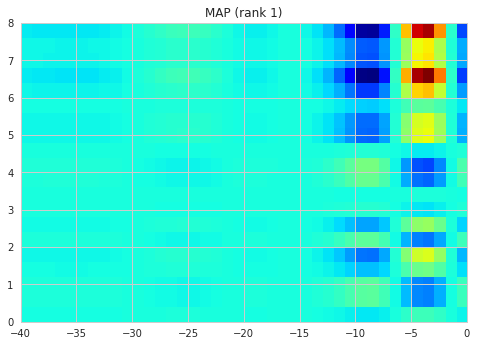

In [12]:
print(w0[:3])
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(mlest.strf(w0), kcosbas)
plt.imshow(rf_mle, extent=(-config["strf"]["ntau"], 0, config["strf"]["f_min"], config["strf"]["f_max"]))
plt.title("MAP (rank {})".format(krank))

In [47]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos

# the MAT parameters are just bounded between reasonable limits. These may need to be expanded when using real data"][
mat_prior = priors.joint_independent(
                [ priors.uniform(config["mat"]["bounds"][0][0], config["mat"]["bounds"][0][1]),
                  priors.uniform(config["mat"]["bounds"][1][0], config["mat"]["bounds"][1][1]),
                  priors.uniform(config["mat"]["bounds"][2][0], config["mat"]["bounds"][2][1]),
                ])

def lnpost(theta):
    """Posterior probability for dynamical parameters"""
    mparams = theta[:3]
    rfparams = theta[3:]
    ll = mat_prior(mparams)
    if not np.isfinite(ll):
        return -np.inf
    w = np.r_[mparams, rfparams]
    ll -= mlest.loglike(w, rf_lambda, rf_alpha)
    return -np.inf if not np.isfinite(ll) else ll


In [ ]:
import emcee
if sys.platform == 'darwin':
    config["emcee"]["nthreads"] = 1

# initialize walkers
pos = p0 = startpos.normal_independent(config["emcee"]["nwalkers"], w0, np.abs(w0) * 2)
# initialize the sampler
sampler = emcee.EnsembleSampler(config["emcee"]["nwalkers"], w0.size, lnpost, 
                                threads=1)

In [ ]:
# start the sampler
tracker = utils.convergence_tracker(config["emcee"]["nsteps"], 10)
for pos, prob, like in tracker(sampler.sample(pos, iterations=1, storechain=True)): 
    continue

In [14]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
try:
    print("autocorrelation time: {}".format(sampler.acor))
except:
    pass    
w1 = np.median(pos, 0)
rfparams = w1[3:]
rf_map = strf.from_basis(mlest.strf(w0), kcosbas)
print(w1[:3])

lnpost of p median: -21898.242634011054
average acceptance fraction: 0.37
[ 5.04353157 -1.3322361   0.0157891 ]


In [15]:
n_ppost = 10
mat.random_seed(1)
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
    
samples = np.random.permutation(config["emcee"]["nwalkers"])[:n_ppost]
pred = np.zeros((test_data["spike_v"].shape[0], n_ppost), dtype=test_data["spike_v"].dtype)
for i, idx in enumerate(samples):
    mparams = pos[idx]
    V_mc = mltest.V(mparams)
    pred[:, i] = mltest.predict(mparams, mat_fixed, V_mc)
    spk_t = pred[:, i].nonzero()[0]

pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)

psth_corr = np.corrcoef(test_psth, pred_psth)[0, 1]
eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)

print("emcee:")
print("loglike: {:.3f}".format(-mltest.loglike(w1)))
print("CC: {:.3f} / {:.3f} ({:.3f})".format(psth_corr, eo, psth_corr/eo))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum() / config["data"]["n_trials"], pred.sum() / n_ppost))

emcee:
loglike: -3953.008
CC: -0.031 / 0.340 (-0.091)
spike count: data = 69.3, pred = 679.6
